In [14]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')


In [15]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
   for filename in filenames:
    paths.append(os.path.join(dirname,filename))
    label = filename.split('_')[-1]
    label = label.split('.')[0]
    labels.append(label.lower())
print('Dataset is loaded')

Dataset is loaded


In [16]:
paths[:5]

['D:\\TYC\\Desktop\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav',
 'D:\\TYC\\Desktop\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav',
 'D:\\TYC\\Desktop\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav',
 'D:\\TYC\\Desktop\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav',
 'D:\\TYC\\Desktop\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']

In [17]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

In [18]:
##Create a dataframe
df = pd.DataFrame()
df['speech']= paths
df['label']= labels
df.head()

,speech,label
0,D:\TYC\Desktop\TESS Toronto emotional speech s...,angry
1,D:\TYC\Desktop\TESS Toronto emotional speech s...,angry
2,D:\TYC\Desktop\TESS Toronto emotional speech s...,angry
3,D:\TYC\Desktop\TESS Toronto emotional speech s...,angry
4,D:\TYC\Desktop\TESS Toronto emotional speech s...,angry


In [19]:
df['label'].value_counts()


label
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

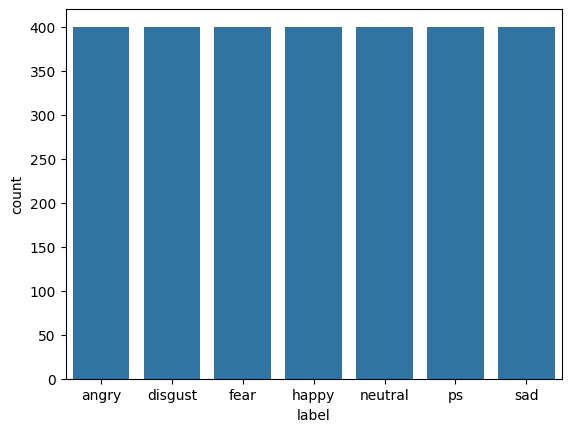

In [20]:
sns.countplot(x='label', data=df)

In [21]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    plt.plot(data)
    plt.show()

def spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    
def stft_preprocessing(data, sr, emotion):
    stft = librosa.stft(data)
    magnitude = np.abs(stft)
    compression_factor = 10.0
    magnitude_compressed = np.log(1.0 + compression_factor * magnitude)
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(magnitude_compressed, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

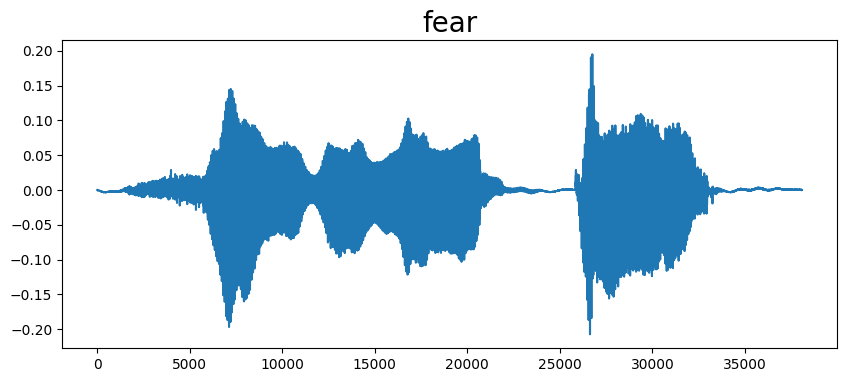

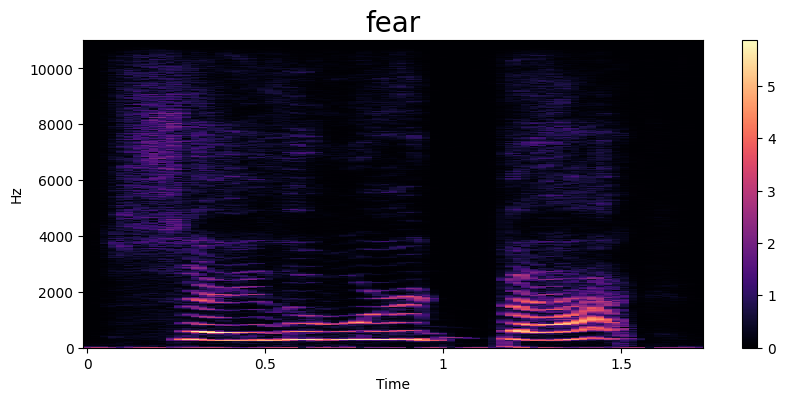

In [22]:
emotion = 'fear'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
stft_preprocessing(data, sampling_rate, emotion)
Audio(path)

In [23]:
import librosa
import numpy as np

def apply_hamming(signal):
    window = np.hamming(len(signal))
    return signal * window

def extract_mfcc_hamming(file_path):
    y, sr = librosa.load(file_path, duration=3)
    
    # Apply Hamming window
    y = apply_hamming(y)  

    # Extract MFCCs
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10).T, axis=0) 

    return mfcc

In [24]:
extract_mfcc_hamming(df['speech'][0])

array([-443.49814923,   49.57788157,  -14.95973694,  -13.64428229,
         -4.37786984,    6.4193477 ,  -22.5866781 ,   -6.21046357,
        -10.13864732,   -3.89326086])

In [25]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc_hamming(x))

In [26]:
X_mfcc

0       [-443.4981492303181, 49.57788156980182, -14.95...
1       [-508.6576680182201, 56.68508269884894, -2.092...
2       [-489.2309999547043, 30.37821921074985, -3.656...
3       [-454.6466591503753, 55.20618365845085, -12.31...
4       [-483.1022142883144, 50.73620026250199, 3.4181...
                              ...                        
2795    [-475.09732180872885, 61.70769730256851, 33.91...
2796    [-482.52169022907043, 72.8513611413188, 26.316...
2797    [-453.41779670180404, 66.61063106797485, 35.65...
2798    [-499.7133326177278, 64.69381882662961, 29.428...
2799    [-494.11799061718415, 52.44087922526784, 32.17...
Name: speech, Length: 2800, dtype: object

In [27]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 10)

In [28]:
X=np.expand_dims(X,-1)
X.shape

(2800, 10, 1)

In [29]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [30]:
y.shape

(2800, 7)

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
y = y.toarray()

In [33]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D

model = Sequential()

# CNN layers 
model.add(Conv1D(16, 3, input_shape=(10,1)))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(32, 3))
model.add(MaxPooling1D(pool_size=2))

# LSTM layers
model.add(LSTM(64))

# Dense layers
model.add(Dense(32, activation='relu')) 
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X, y, epochs=100, batch_size=128,validation_split=0.2)

train_acc = history.history['accuracy'][-1]

print('Train accuracy:', train_acc)






Epoch 1/100


18/18 [==============================] - 3s 43ms/step - loss: 1.8213 - accuracy: 0.3067 - val_loss: 2.0203 - val_accuracy: 0.0429
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 1.5799 - accuracy: 0.4527 - val_loss: 2.1684 - val_accuracy: 0.0357
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 1.3710 - accuracy: 0.5397 - val_loss: 2.2754 - val_accuracy: 0.0518
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 1.1578 - accuracy: 0.6112 - val_loss: 2.2127 - val_accuracy: 0.1089
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 0.9602 - accuracy: 0.6857 - val_loss: 2.1118 - val_accuracy: 0.2036
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 0.8170 - accuracy: 0.7348 - val_loss: 2.1968 - val_accuracy: 0.2607
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 0.7125 - accuracy: 0.7571 - val_loss: 2.3750 - val_accuracy: 0.1625
Epoch 

In [35]:
# Predict on validation data
y_pred = model.predict(X)

# Convert the predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

88/88 [==============================] - 1s 2ms/step


In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Convert the one-hot encoded labels back to categorical labels
y_true_labels = np.argmax(y, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Calculate accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Confusion Matrix:")
print(conf_matrix)

print("Accuracy:", accuracy)

Confusion Matrix:
[[398   0   1   1   0   0   0]
 [  0 396   1   0   1   2   0]
 [  3   0 388   7   1   1   0]
 [  0   0   4 395   0   1   0]
 [  0  24  16   0 359   0   1]
 [ 97  13  98  15   0 177   0]
 [  0 152   0   0  23   0 225]]
Accuracy: 0.835


In [38]:
# Training accuracy
train_acc = history.history['accuracy'][-1]

# Validation accuracy
val_acc = history.history['val_accuracy'][-1]

print("Training accuracy:", train_acc)  
print("Validation accuracy:", val_acc)


avg_acc = (train_acc + val_acc) / 2
print("Average Accuracy:", avg_acc)

Training accuracy: 0.9772321581840515
Validation accuracy: 0.2589285671710968
Average Accuracy: 0.6180803626775742


In [43]:
model.save('emotion_model.h5')

In [44]:
import joblib

In [47]:
print('Test Acc:', train_acc)

# Save Keras model
model.save('emotion_model.h5')

# Save using joblib
joblib.dump(model, 'emotion_model.joblib') 

print('Saved model!')

Test Acc: 0.9772321581840515
Saved model!


In [48]:
import tkinter as tk
from tkinter import filedialog
import joblib
import librosa

# Load pretrained model
model = joblib.load('emotion_model.joblib') 
from scipy.signal import hamming
# Audio feature extraction function

import numpy as np

def apply_hamming(signal):
    window = np.hamming(len(signal))
    return signal * window

def extract_mfcc_hamming(file_path):
    y, sr = librosa.load(file_path, duration=3)
    
    # Apply Hamming window
    y = apply_hamming(y)  

    # Extract MFCCs
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0) 

    return mfcc


# Predict emotion    
def predict(file_path):
    features = extract_features(file_path)
    features = features.reshape((-1, 10, 1))
    
    prediction = model.predict(features)[0] 
    predicted_index = np.argmax(prediction)
    return predicted_index

# GUI    
root = tk.Tk() 
root.geometry('500x100')
root.title("Emotion Recognition")   

def upload():
    file_path = filedialog.askopenfilename()
    predicted_class = predict(file_path) 
    
    emo_label = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Pleasant Surprise', 'Sad']  
    emo_prediction = emo_label[predicted_class]
    
    tk.Label(text=emo_prediction).grid(row=3, column=0, padx=10)
    
tk.Button(text="Select Audio", command=upload).grid(row=1, column=0)

root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\tanea\anaconda3\envs\PSM\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\tanea\AppData\Local\Temp\ipykernel_10740\3272213403.py", line 45, in upload
    predicted_class = predict(file_path)
  File "C:\Users\tanea\AppData\Local\Temp\ipykernel_10740\3272213403.py", line 31, in predict
    features = extract_features(file_path)
NameError: name 'extract_features' is not defined
